## Image segmentation using camvid example to apply to imaterialist dataset

used mask generation code from https://www.kaggle.com/solpaul/fastai-factory-approach-using-mask-images as my base.

Data from https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!python3.7 -m pip install progressbar

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
import os
import json
from progressbar import ProgressBar


In [4]:
path = Path('/home/finlay_macrae/kaggle/imaterialist')
path.ls()

[PosixPath('/home/finlay_macrae/kaggle/imaterialist/train'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/label_descriptions.json'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/train.csv.zip'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/test'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/labels'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/sample_submission.csv'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/test.zip'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/train.zip'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/train.csv')]

In [32]:
path_lbl = path/'labels'
path_img = path/'train'
path_models = path/'models'

In [33]:
# create a folder for the mask images
if  not os.path.isdir(path_lbl):
    os.makedirs(path_lbl)
if  not os.path.isdir(path_models):
    os.makedirs(path_models)
    

In [60]:
# only the 27 apparel items, plus 1 for background
# model image size 224x224
category_num = 27 + 1
model_size = 224
size = model_size


# get and show categories
with open(path/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
print(label_names)

# train dataframe
df = pd.read_csv(path/'train.csv')

['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']


In [8]:
# need a function to turn the run encoded pixels from train.csv into an image mask
# there are multiple rows per image for different apparel items, this groups them into one mask
def make_mask_img(segment_df):
    seg_width = segment_df.at[0, "Width"]
    seg_height = segment_df.at[0, "Height"]
    seg_img = np.full(seg_width*seg_height, category_num-1, dtype=np.int32)
    for encoded_pixels, class_id in zip(segment_df["EncodedPixels"].values, segment_df["ClassId"].values):
        pixel_list = list(map(int, encoded_pixels.split(" ")))
        for i in range(0, len(pixel_list), 2):
            start_index = pixel_list[i] - 1
            index_len = pixel_list[i+1] - 1
            if int(class_id.split("_")[0]) < category_num - 1:
                seg_img[start_index:start_index+index_len] = int(class_id.split("_")[0])
    seg_img = seg_img.reshape((seg_height, seg_width), order='F')
    return seg_img

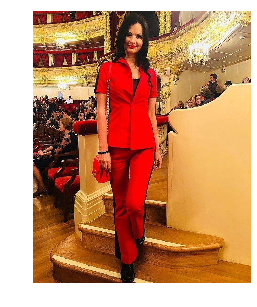

In [9]:
# we can look at an image to see how the processing works
# the original image
# training jpg images are in the train folder
fnames = get_image_files(path_img)

img_file = fnames[500]
img = open_image(img_file)
img.show(figsize=(5,5))

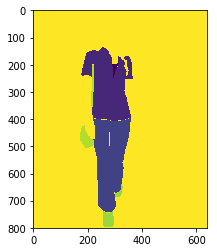

In [10]:
# convert rows for this image into a numpy array mask 
img_name = os.path.basename(img_file)
img_df = df[df.ImageId == img_name].reset_index()
#img_df = img_df.iloc[0:1]
#img_df = img_df[img_df.ClassId.astype(int) < category_num - 1].reset_index()
img_mask = make_mask_img(img_df)
plt.imshow(img_mask)

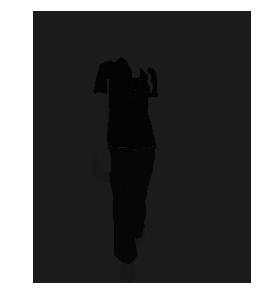

In [11]:
# convert the numpy array into a three channel png that can be used in the standard SegmentationItemList
# then write into the labels folder as png and show the image
# all pixels have the category numbers, so it looks like a dark greyscale image
img_mask_3_chn = np.dstack((img_mask, img_mask, img_mask))
cv2.imwrite(str(path_lbl) + '/' + os.path.splitext(img_name)[0] + '_P.png', img_mask_3_chn)
png = open_image(str(path_lbl) + '/' + os.path.splitext(img_name)[0] + '_P.png')
png.show(figsize=(5,5))

tensor([[[27, 27, 27,  ..., 27, 27, 27],
         [27, 27, 27,  ..., 27, 27, 27],
         [27, 27, 27,  ..., 27, 27, 27],
         ...,
         [27, 27, 27,  ..., 27, 27, 27],
         [27, 27, 27,  ..., 27, 27, 27],
         [27, 27, 27,  ..., 27, 27, 27]]])


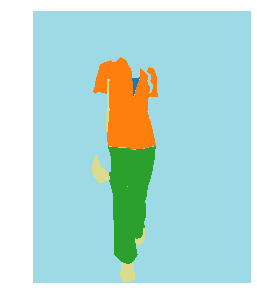

In [12]:
# use fastai's open_mask for an easier-to-view image (and check it works...)
mask = open_mask(str(path_lbl) + '/' + os.path.splitext(img_name)[0] + '_P.png')
mask.show(figsize=(5,5), alpha=1)
print(mask.data)

## Produce the masks

In [13]:
images = df.ImageId.unique()

In [14]:
pbar = ProgressBar()
#uncomment if you want to create the mask images again.
#for img in pbar(images):
#    img_df = df[df.ImageId == img].reset_index()
#    img_mask = make_mask_img(img_df)
#    img_mask_3_chn = np.dstack((img_mask, img_mask, img_mask))
#    cv2.imwrite(str(path_lbl) + '/' + os.path.splitext(img)[0] + '_P.png', img_mask_3_chn)

## Data

In [15]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/finlay_macrae/kaggle/imaterialist/train/53d0ee82b3b7200b3cec8c3c1becead9.jpg'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/train/a97cba8b0438fbb495c1852faa748c46.jpg'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/train/34ed189ba23831d1365983dfbf984200.jpg')]

In [16]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/finlay_macrae/kaggle/imaterialist/labels/6e5175726c44451800a89666d7e6513f_P.png'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/labels/e2981e6fa1e2734e760f02b056cb5146_P.png'),
 PosixPath('/home/finlay_macrae/kaggle/imaterialist/labels/4d0bcfd4beefc4f584e790f053b31527_P.png')]

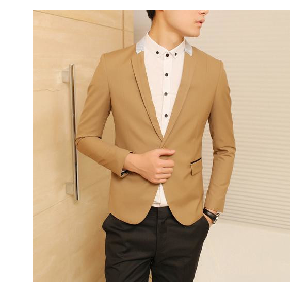

In [17]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [18]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P.png'

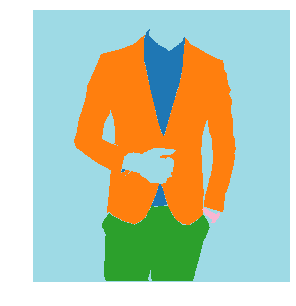

In [19]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [20]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([528, 498]), tensor([[[27, 27, 27,  ..., 27, 27, 27],
          [27, 27, 27,  ..., 27, 27, 27],
          [27, 27, 27,  ..., 27, 27, 27],
          ...,
          [27, 27, 27,  ..., 27, 27, 27],
          [27, 27, 27,  ..., 27, 27, 27],
          [27, 27, 27,  ..., 27, 27, 27]]]))

In [21]:
codes = label_names #np.loadtxt(path/'codes.txt', dtype=str); codes
codes

['shirt, blouse',
 'top, t-shirt, sweatshirt',
 'sweater',
 'cardigan',
 'jacket',
 'vest',
 'pants',
 'shorts',
 'skirt',
 'coat',
 'dress',
 'jumpsuit',
 'cape',
 'glasses',
 'hat',
 'headband, head covering, hair accessory',
 'tie',
 'glove',
 'watch',
 'belt',
 'leg warmer',
 'tights, stockings',
 'sock',
 'shoe',
 'bag, wallet',
 'scarf',
 'umbrella',
 'hood',
 'collar',
 'lapel',
 'epaulette',
 'sleeve',
 'pocket',
 'neckline',
 'buckle',
 'zipper',
 'applique',
 'bead',
 'bow',
 'flower',
 'fringe',
 'ribbon',
 'rivet',
 'ruffle',
 'sequin',
 'tassel']

## Datasets

In [61]:
size = model_size//2


free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 5676MB of GPU RAM free


In [62]:
size

112

In [63]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.1)
       .label_from_func(get_y_fn, classes=codes))

In [64]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
        )

In [65]:
help(src.transform)

Help on method transform in module fastai.data_block:

transform(tfms: Union[Tuple[Union[Callable, Collection[Callable]], Union[Callable, Collection[Callable]]], NoneType] = (None, None), **kwargs) method of fastai.data_block.LabelLists instance
    Set `tfms` to be applied to the xs of the train and validation set.



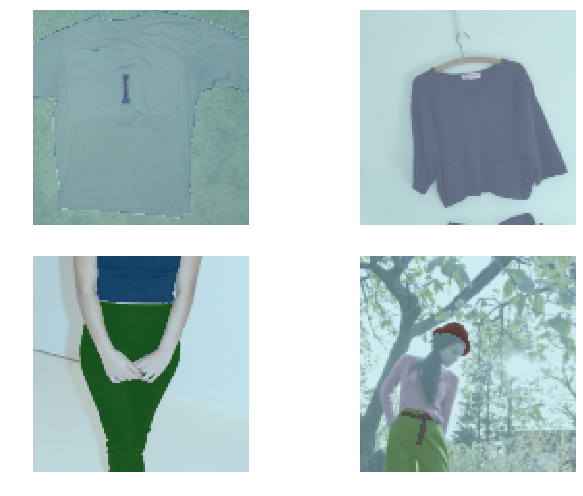

In [66]:
data.show_batch(2, figsize=(10,7))

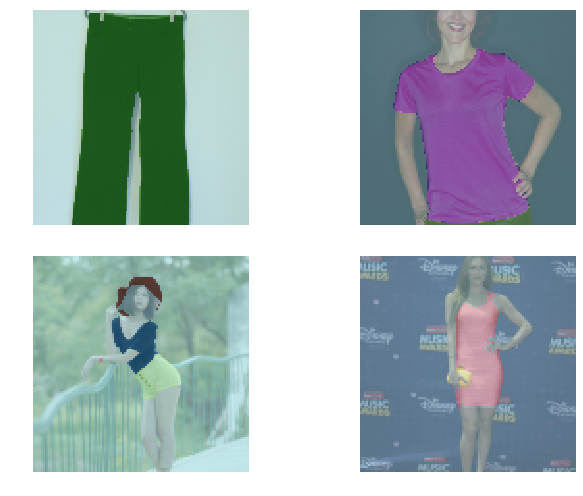

In [67]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [68]:
# I create an accuracy metric which excludes the background pixels
# not sure if this is correct
def acc_fashion(input, target):
    target = target.squeeze(1)
    mask = target != category_num - 1
    return (input.argmax(dim=1)==target).float().mean()

In [69]:
metrics=acc_fashion

In [70]:
wd=1e-2

In [71]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, model_dir=path_models)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


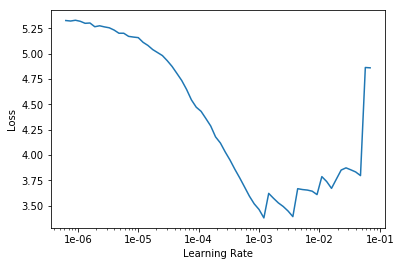

In [72]:
lr_find(learn)
learn.recorder.plot()

In [73]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(11, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_fashion,time


In [24]:
learn.save('stage-1')

In [25]:
learn.load('stage-1');

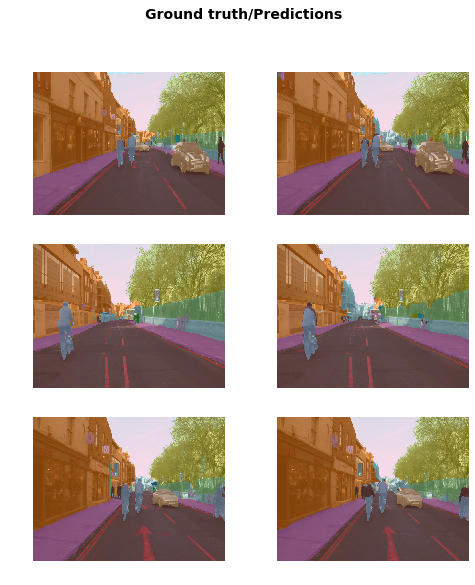

In [31]:
learn.show_results(rows=3, figsize=(8,9))

In [27]:
learn.unfreeze()

In [28]:
lrs = slice(lr/400,lr/4)

In [29]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.381353,0.328648,0.903078,01:51
1,0.363584,0.318391,0.905617,01:53
2,0.367372,0.326658,0.904318,01:53
3,0.358090,0.314945,0.912000,01:53
4,0.353264,0.310160,0.911518,01:56
5,0.334440,0.319622,0.913880,01:57
6,0.335040,0.299594,0.914152,01:54
7,0.320266,0.301307,0.913251,01:54
8,0.319589,0.305931,0.913489,01:54
9,0.311109,0.328808,0.902241,01:54


In [30]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [29]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 6722MB of GPU RAM free


In [30]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [31]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [32]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


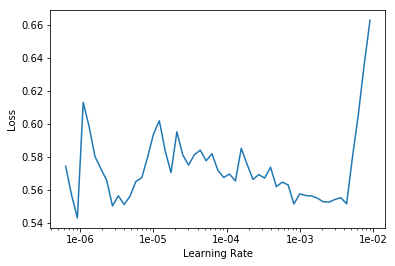

In [33]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr=1e-3

In [38]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.451320,0.342978,0.906943,07:27
1,0.390252,0.330106,0.910551,07:30
2,0.372955,0.304367,0.917466,07:31
3,0.366629,0.314340,0.910523,07:32
4,0.333793,0.384497,0.912480,07:30
5,0.358070,0.322335,0.918542,07:29
6,0.389822,0.328418,0.907508,07:30
7,0.354238,0.340124,0.910085,07:29
8,0.282485,0.307847,0.920207,07:29
9,0.230944,0.281250,0.925867,07:29


In [39]:
learn.save('stage-1-big')

In [37]:
learn.load('stage-1-big');

In [38]:
learn.unfreeze()

In [39]:
lrs = slice(1e-6,lr/10)

In [40]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.224320,0.280214,0.927533,07:41
1,0.218876,0.280344,0.927861,07:43
2,0.210066,0.292553,0.925429,07:43
3,0.219229,0.266134,0.931194,07:43
4,0.200287,0.269709,0.928821,07:43
5,0.209687,0.286327,0.925574,07:43
6,0.190344,0.274823,0.929013,07:43
7,0.195949,0.275316,0.929235,07:43
8,0.176434,0.277476,0.928157,07:44
9,0.197493,0.273135,0.929187,07:43


In [41]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

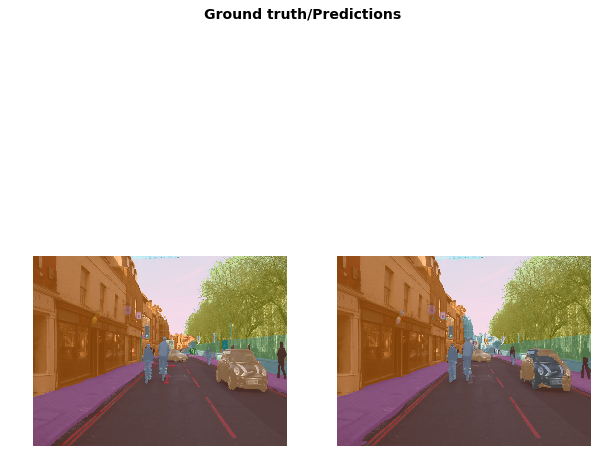

In [42]:
learn.show_results(rows=3, figsize=(10,10))

In [43]:
!pwd

/home/jupyter/tutorials/fastai/course-v3/nbs/dl1


## fin